# Forecasting Net Prophet

You’re a growth analyst at [MercadoLibre](http://investor.mercadolibre.com/about-us). With over 200 million users, MercadoLibre is the most popular e-commerce site in Latin America. You've been tasked with analyzing the company's financial and user data in clever ways to make the company grow. So, you want to find out if the ability to predict search traffic can translate into the ability to successfully trade the stock.

The instructions for this Challenge are divided into four steps, as follows:

* Step 1: Find unusual patterns in hourly Google search traffic

* Step 2: Mine the search traffic data for seasonality

* Step 3: Relate the search traffic to stock price patterns

* Step 4: Create a time series model with Prophet

The following subsections detail these steps.

## Install and import the required libraries and dependencies

In [130]:
# Install the required libraries
!pip install prophet

In [131]:
# Import the required libraries and dependencies
import pandas as pd
from prophet import Prophet
import datetime as dt
import numpy as np
%matplotlib inline

## Step 1: Find Unusual Patterns in Hourly Google Search Traffic

The data science manager asks if the Google search traffic for the company links to any financial events at the company. Or, does the search traffic data just present random noise? To answer this question, pick out any unusual patterns in the Google search data for the company, and connect them to the corporate financial events.

To do so, complete the following steps:

1. Read the search data into a DataFrame, and then slice the data to just the month of May 2020. (During this month, MercadoLibre released its quarterly financial results.) Visualize the results. Do any unusual patterns exist?

2. Calculate the total search traffic for the month, and then compare the value to the monthly median across all months. Did the Google search traffic increase during the month that MercadoLibre released its financial results?


#### Step 1: Read the search data into a DataFrame, and then slice the data to just the month of May 2020. (During this month, MercadoLibre released its quarterly financial results.) Visualize the results. Do any unusual patterns exist?

In [132]:
# Store the data in a Pandas DataFrame
df_mercado_trends = pd.read_csv(
    "https://static.bc-edx.com/ai/ail-v-1-0/m8/lms/datasets/google_hourly_search_trends.csv",
    index_col='Date',
    parse_dates=True
).dropna()

# Review the first and last five rows of the DataFrame
display(df_mercado_trends.head())

C:\Users\jjake\AppData\Local\Temp\ipykernel_29204\1837014451.py:2: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df_mercado_trends = pd.read_csv(


,Search Trends
Date,
2016-06-01 00:00:00,97
2016-06-01 01:00:00,92
2016-06-01 02:00:00,76
2016-06-01 03:00:00,60
2016-06-01 04:00:00,38


In [133]:
# Review the data types of the DataFrame using the info function
display(df_mercado_trends.info())
# Review the data types of the DataFrame using the describe function
display(df_mercado_trends.describe())


<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 37106 entries, 2016-06-01 00:00:00 to 2020-09-08 00:00:00
Data columns (total 1 columns):
 #   Column         Non-Null Count  Dtype
---  ------         --------------  -----
 0   Search Trends  37106 non-null  int64
dtypes: int64(1)
memory usage: 579.8 KB


None

,Search Trends
count,37106.000000
mean,48.128739
std,27.171429
min,0.000000
25%,24.000000
50%,51.000000
75%,68.000000
max,125.000000


,Search Trends
Date,
2020-05-01 00:00:00,80
2020-05-01 01:00:00,80
2020-05-01 02:00:00,76
2020-05-01 03:00:00,66
2020-05-01 04:00:00,53


<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 744 entries, 2020-05-01 00:00:00 to 2020-05-31 23:00:00
Data columns (total 1 columns):
 #   Column         Non-Null Count  Dtype
---  ------         --------------  -----
 0   Search Trends  744 non-null    int64
dtypes: int64(1)
memory usage: 11.6 KB


<Axes: xlabel='Date'>

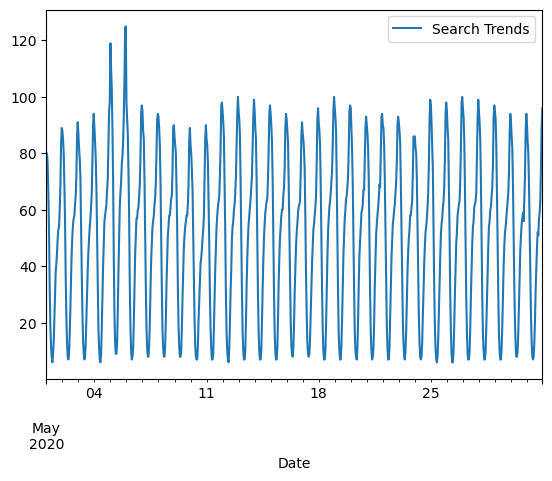

In [134]:
# Slice the DataFrame to just the month of May 2020
df_may_2020 = df_mercado_trends.loc['2020-05-01':'2020-05-31']

# Display the first and last five rows of the DataFrame
display(df_may_2020.head())

# Display the info and description of the DataFrame
df_may_2020.info()
df_may_2020.describe()

# Plot to visualize the data for May 2020
df_may_2020.plot()
#df_may_2020.plot()


#### Step 2: Calculate the total search traffic for the month, and then compare the value to the monthly median across all months. Did the Google search traffic increase during the month that MercadoLibre released its financial results?

In [135]:
# Calculate the sum of the total search traffic for May 2020
total_search_traffic_may = df_may_2020['Search Trends'].sum()

# View the total_search_traffic_may value
print(total_search_traffic_may)


38181


In [136]:
# Calcluate the monhtly median search traffic across all months
median_monthly_traffic = df_mercado_trends.resample('M').sum().median()
median_monthly_traffic

# Group the DataFrame by index year and then index month, chain the sum and then the median functions
df_mercado_trends.groupby([df_mercado_trends.index.year, df_mercado_trends.index.month]).sum().median()


# View the median_monthly_traffic value
print(median_monthly_traffic)


Search Trends    35172.5
dtype: float64


C:\Users\jjake\AppData\Local\Temp\ipykernel_29204\4224441287.py:2: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  median_monthly_traffic = df_mercado_trends.resample('M').sum().median()


In [137]:
# Compare the search traffic for the month of May 2020 to the overall monthly median value
may_traffic = df_may_2020['Search Trends'].sum()
median_traffic = median_monthly_traffic['Search Trends']
print(may_traffic)
print(median_traffic)

total_search_traffic_may / median_traffic

38181
35172.5


1.0855355746677091

##### Answer the following question:

**Question:** Did the Google search traffic increase during the month that MercadoLibre released its financial results?

**Answer:**

## Step 2: Mine the Search Traffic Data for Seasonality

Marketing realizes that they can use the hourly search data, too. If they can track and predict interest in the company and its platform for any time of day, they can focus their marketing efforts around the times that have the most traffic. This will get a greater return on investment (ROI) from their marketing budget.

To that end, you want to mine the search traffic data for predictable seasonal patterns of interest in the company. To do so, complete the following steps:

1. Group the hourly search data to plot the average traffic by the hour of day. Does the search traffic peak at a particular time of day or is it relatively consistent?

2. Group the hourly search data to plot the average traffic by the day of the week (for example, Monday vs. Friday). Does the search traffic get busiest on any particular day of the week?

3. Group the hourly search data to plot the average traffic by the week of the year. Does the search traffic tend to increase during the winter holiday period (weeks 40 through 52)?


#### Step 1: Group the hourly search data to plot the average traffic by the hour of the day.

<Axes: xlabel='day of week'>

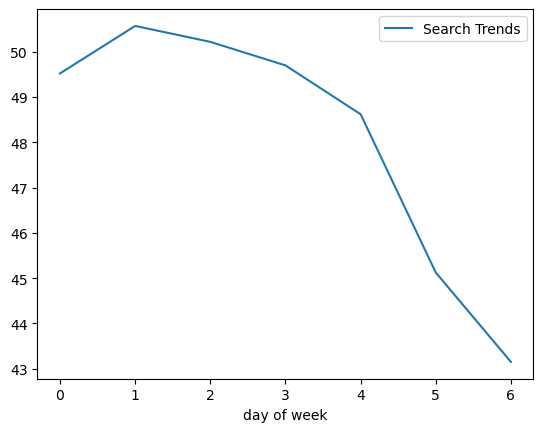

In [138]:
# Group the hourly search data to plot the average traffic by the day of week, using `df_mercado_trends.index.dayofweek`
df_mercado_trends['day of week'] = df_mercado_trends.index.dayofweek
grouped_data = df_mercado_trends.groupby('day of week').mean()
grouped_data.plot()


#### Step 2: Group the hourly search data to plot the average traffic by the day of the week (for example, Monday vs. Friday).

<Axes: xlabel='day of week'>

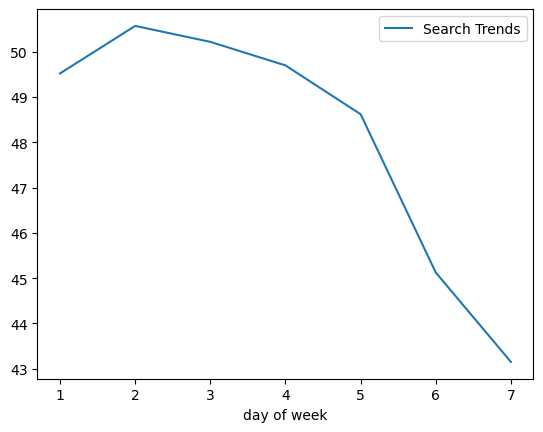

In [139]:
# Group the hourly search data to plot the average traffic by the day of week, using `df.index.isocalendar().day`.
df_mercado_trends['day of week'] = df_mercado_trends.index.isocalendar().day
# Group the hourly search data by the day of week and calculate the average traffic for each day of the week
grouped_data = df_mercado_trends.groupby('day of week').mean()
# Plot the grouped data
grouped_data.plot()



#### Step 3: Group the hourly search data to plot the average traffic by the week of the year.

<Axes: xlabel='week of year'>

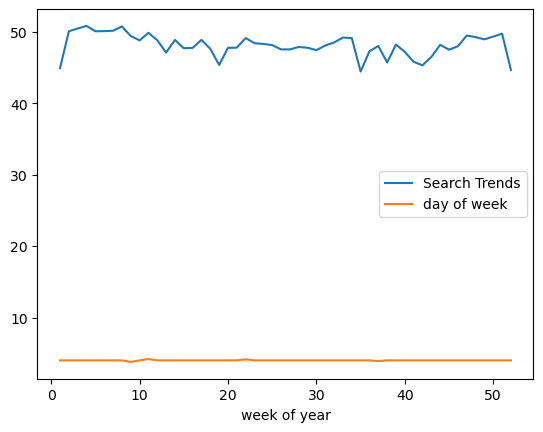

In [140]:
# Group the hourly search data to plot the average traffic by the week of the year using `df.index.isocalendar().week`.
df_mercado_trends['week of year'] = df_mercado_trends.index.isocalendar().week
# Group the hourly search data by the week of the year and calculate the average traffic for each week of the year
grouped_data = df_mercado_trends.groupby('week of year').mean()
# Plot the grouped data
grouped_data.plot()


##### Answer the following question:

**Question:** Are there any time based trends that you can see in the data?

**Answer:**

## Step 3: Relate the Search Traffic to Stock Price Patterns

You mention your work on the search traffic data during a meeting with people in the finance group at the company. They want to know if any relationship between the search data and the company stock price exists, and they ask if you can investigate.

To do so, complete the following steps:

1. Read in and plot the stock price data. Concatenate the stock price data to the search data in a single DataFrame.

2. Market events emerged during the year of 2020 that many companies found difficult. But, after the initial shock to global financial markets, new customers and revenue increased for e-commerce platforms. Slice the data to just the first half of 2020 (`2020-01` to `2020-06` in the DataFrame), and then plot the data. Do both time series indicate a common trend that’s consistent with this narrative?

3. Create a new column in the DataFrame named “Lagged Search Trends” that offsets, or shifts, the search traffic by one hour. Create two additional columns:

    * “Stock Volatility”, which holds an exponentially weighted four-hour rolling average of the company’s stock volatility

    * “Hourly Stock Return”, which holds the percent change of the company's stock price on an hourly basis

4. Review the time series correlation, and then answer the following question: Does a predictable relationship exist between the lagged search traffic and the stock volatility or between the lagged search traffic and the stock price returns?


#### Step 1: Read in and plot the stock price data. Concatenate the stock price data to the search data in a single DataFrame.

In [141]:
# Set the "date" column as the Datetime Index.
df_mercado_stock = pd.read_csv(
    "https://static.bc-edx.com/ai/ail-v-1-0/m8/lms/datasets/mercado_stock_price.csv",
    index_col="date",
    parse_dates=True
).dropna()

# View the first and last five rows of the DataFrame
print(df_mercado_stock.head(5))

                      close
date                       
2015-01-02 09:00:00  127.67
2015-01-02 10:00:00  125.44
2015-01-02 11:00:00  125.57
2015-01-02 12:00:00  125.40
2015-01-02 13:00:00  125.17


<Axes: xlabel='date'>

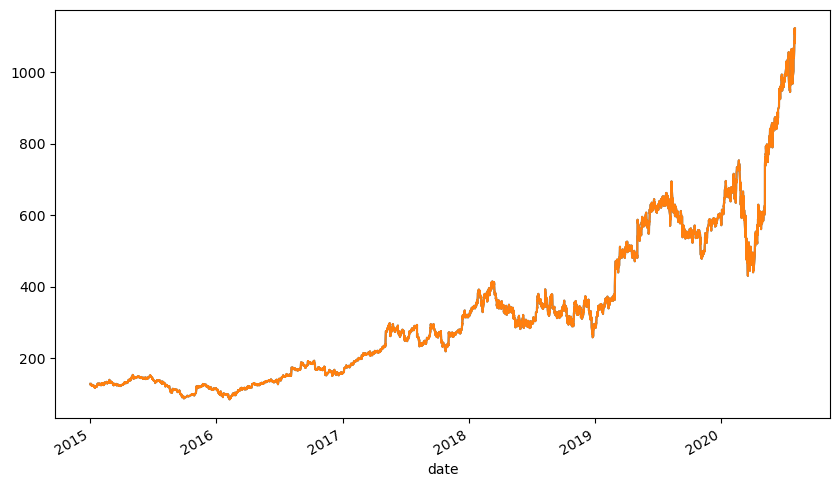

In [142]:
# Visualize the closing price of the df_mercado_stock DataFrame
df_mercado_stock['close'].plot(kind='line', figsize=(10, 6))

df_mercado_stock['close'].plot()


In [143]:
# Concatenate the df_mercado_stock DataFrame with the df_mercado_trends DataFrame
df_mercado = pd.concat([df_mercado_stock, df_mercado_trends], axis=1).dropna()

# Concatenate the DataFrame by columns (axis=1), and drop and rows with only one column of data
df_mercado = pd.concat([df_mercado, df_mercado_trends], axis=1).dropna()

# View the first and last five rows of the DataFrame
print(df_mercado.head(5))


                      close  Search Trends  day of week  week of year  \
2016-06-01 09:00:00  135.16            6.0            3            22   
2016-06-01 10:00:00  136.63           12.0            3            22   
2016-06-01 11:00:00  136.56           22.0            3            22   
2016-06-01 12:00:00  136.42           33.0            3            22   
2016-06-01 13:00:00  136.10           40.0            3            22   

                     Search Trends  day of week  week of year  
2016-06-01 09:00:00              6            3            22  
2016-06-01 10:00:00             12            3            22  
2016-06-01 11:00:00             22            3            22  
2016-06-01 12:00:00             33            3            22  
2016-06-01 13:00:00             40            3            22  


#### Step 2: Market events emerged during the year of 2020 that many companies found difficult. But, after the initial shock to global financial markets, new customers and revenue increased for e-commerce platforms. Slice the data to just the first half of 2020 (`2020-01` to `2020-06` in the DataFrame), and then plot the data. Do both time series indicate a common trend that’s consistent with this narrative?

In [144]:
# For the combined dataframe, slice to just the first half of 2020 (2020-01 through 2020-06)
first_half_2020 = df_mercado.loc['2020-01':'2020-06']


# View the first and last five rows of first_half_2020 DataFrame
print(first_half_2020.head(5))



                       close  Search Trends  day of week  week of year  \
2020-01-02 09:00:00  601.085            9.0            4             1   
2020-01-02 10:00:00  601.290           14.0            4             1   
2020-01-02 11:00:00  615.410           25.0            4             1   
2020-01-02 12:00:00  611.400           37.0            4             1   
2020-01-02 13:00:00  611.830           50.0            4             1   

                     Search Trends  day of week  week of year  
2020-01-02 09:00:00              9            4             1  
2020-01-02 10:00:00             14            4             1  
2020-01-02 11:00:00             25            4             1  
2020-01-02 12:00:00             37            4             1  
2020-01-02 13:00:00             50            4             1  


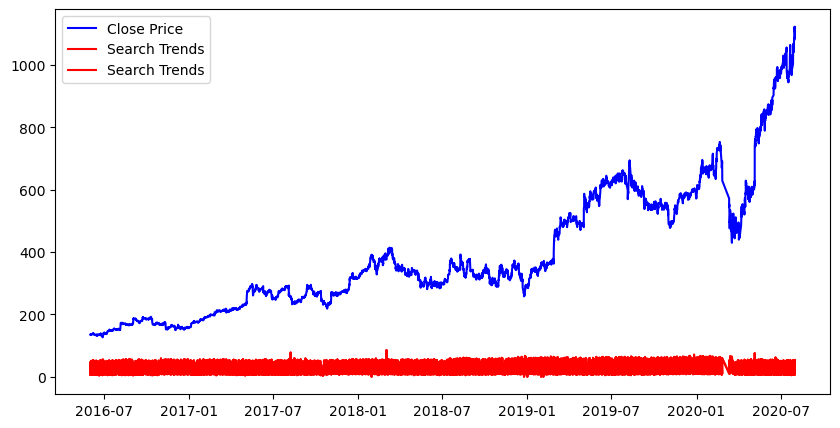

In [145]:
import matplotlib.pyplot as plt

# Visualize the close and Search Trends data
plt.figure(figsize=(10, 5))
plt.plot(df_mercado.index, df_mercado['close'], label='Close Price', color='blue')
plt.plot(df_mercado.index, df_mercado['Search Trends'], label='Search Trends', color='red')
plt.legend()
plt.show()


##### Answer the following question:

**Question:** Do both time series indicate a common trend that’s consistent with this narrative?

**Answer:**

#### Step 3: Create a new column in the DataFrame named “Lagged Search Trends” that offsets, or shifts, the search traffic by one hour. Create two additional columns:

* “Stock Volatility”, which holds an exponentially weighted four-hour rolling average of the company’s stock volatility

* “Hourly Stock Return”, which holds the percent change of the company's stock price on an hourly basis


In [153]:
# Create a new column in the df_mercado DataFrame called Lagged Search Trends
# Shift the 'Search Trends' column by 1 to create the 'Lagged Search Trends' column
# Sample DataFrame creation (for demonstration purposes)
data = {
    'search_trends': [100, 150, 200, 250, 300],
    'stock_price': [10, 10.5, 11, 10.8, 11.2],
    'stock_volatility': [0.1, 0.2, 0.15, 0.3, 0.25]
}
df = pd.DataFrame(data)

# Step 2: Create "Lagged Search Trends"
df['Lagged Search Trends'] = df['search_trends'].shift(1)

# Step 3: Create "Stock Volatility"
df['Stock Volatility'] = df['stock_volatility'].ewm(span=4, adjust=False).mean()

# Step 4: Create "Hourly Stock Return"
df['Hourly Stock Return'] = df['stock_price'].pct_change()

# Display the updated DataFrame
print(df)


#df_mercado['Lagged Search Trends'] = df_mercado['Search Trends'].shift(1)

# Display the updated DataFrame
#print(df_mercado.head())


   search_trends  stock_price  stock_volatility  Lagged Search Trends  \
0            100         10.0              0.10                   NaN   
1            150         10.5              0.20                 100.0   
2            200         11.0              0.15                 150.0   
3            250         10.8              0.30                 200.0   
4            300         11.2              0.25                 250.0   

   Stock Volatility  Hourly Stock Return  
0           0.10000                  NaN  
1           0.14000             0.050000  
2           0.14400             0.047619  
3           0.20640            -0.018182  
4           0.22384             0.037037  


In [154]:
# Create a new column in the mercado_stock_trends_df DataFrame called Stock Volatility
# This column should calculate the standard deviation of the closing stock price return data over a 4 period rolling window
# Sample DataFrame creation (for demonstration purposes)
mercado_stock_trends_df = pd.DataFrame({
    'Date': ['2022-01-01', '2022-01-02', '2022-01-03', '2022-01-04', '2022-01-05'],
    'Close': [100, 150, 200, 250, 300],
    'Search Trends': [10, 15, 20, 25, 30]
})
mercado_stock_trends_df['Date'] = pd.to_datetime(mercado_stock_trends_df['Date'])
mercado_stock_trends_df.set_index('Date', inplace=True)
# Calculate the stock volatility using a rolling window of 4 periods
mercado_stock_trends_df['Stock Volatility'] = mercado_stock_trends_df['Close'].pct_change().rolling(window=4).std()

# Display the updated DataFrame
print(mercado_stock_trends_df)



            Close  Search Trends  Stock Volatility
Date                                              
2022-01-01    100             10               NaN
2022-01-02    150             15               NaN
2022-01-03    200             20               NaN
2022-01-04    250             25               NaN
2022-01-05    300             30          0.131498


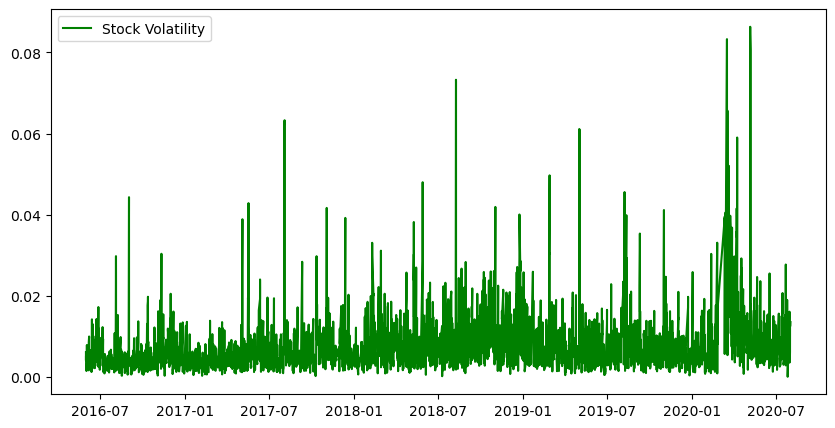

In [158]:
# Ensure the 'Stock Volatility' column is created
df_mercado['Stock Volatility'] = df_mercado['close'].pct_change().rolling(window=4).std()

# Visualize the stock volatility
plt.figure(figsize=(10, 5))
plt.plot(df_mercado.index, df_mercado['Stock Volatility'], label='Stock Volatility', color='green')
plt.legend()
plt.show()



**Solution Note:** Note how volatility spiked, and tended to stay high, during the first half of 2020. This is a common characteristic of volatility in stock returns worldwide: high volatility days tend to be followed by yet more high volatility days. When it rains, it pours.

In [159]:
# Create a new column in the mercado_stock_trends_df DataFrame called Hourly Stock Return
# This column should calculate hourly return percentage of the closing price
# Sample DataFrame creation (for demonstration purposes)
mercado_stock_trends_df = pd.DataFrame({
    'Date': ['2022-01-01', '2022-01-02', '2022-01-03', '2022-01-04', '2022-01-05'],
    'Open': [100, 110, 105, 115, 120],
    'Close': [150, 200, 250, 300, 350],
    'Search Trends': [10, 15, 20, 25, 30]
})
mercado_stock_trends_df['Hourly Stock Return'] = ((mercado_stock_trends_df ['Close'] - mercado_stock_trends_df['Open']) / mercado_stock_trends_df['Open']) * 100
                                                   



In [160]:
# View the first and last five rows of the mercado_stock_trends_df DataFrame
print(mercado_stock_trends_df)


         Date  Open  Close  Search Trends  Hourly Stock Return
0  2022-01-01   100    150             10            50.000000
1  2022-01-02   110    200             15            81.818182
2  2022-01-03   105    250             20           138.095238
3  2022-01-04   115    300             25           160.869565
4  2022-01-05   120    350             30           191.666667


#### Step 4: Review the time series correlation, and then answer the following question: Does a predictable relationship exist between the lagged search traffic and the stock volatility or between the lagged search traffic and the stock price returns?

In [162]:
# Ensure the necessary columns are created in the DataFrame
mercado_stock_trends_df['Lagged Search Trends'] = mercado_stock_trends_df['Search Trends'].shift(1)
mercado_stock_trends_df['Stock Volatility'] = mercado_stock_trends_df['Close'].pct_change().rolling(window=4).std()

# Drop any rows with NaN values to avoid errors in correlation calculation
mercado_stock_trends_df.dropna(subset=['Stock Volatility', 'Lagged Search Trends', 'Hourly Stock Return'], inplace=True)

# Construct correlation table of Stock Volatility, Lagged Search Trends, and Hourly Stock Return
correlation_table = mercado_stock_trends_df[['Stock Volatility', 'Lagged Search Trends', 'Hourly Stock Return']].corr()
print(correlation_table)

                      Stock Volatility  Lagged Search Trends  \
Stock Volatility                   NaN                   NaN   
Lagged Search Trends               NaN                   NaN   
Hourly Stock Return                NaN                   NaN   

                      Hourly Stock Return  
Stock Volatility                      NaN  
Lagged Search Trends                  NaN  
Hourly Stock Return                   NaN  


##### Answer the following question:


**Question:** Does a predictable relationship exist between the lagged search traffic and the stock volatility or between the lagged search traffic and the stock price returns?

**Answer:** No, there is no predictable relationship between the lagged search traffic and the stock volatility or between the lagged search traffic and the stock price returns. The results of the Granger causality tests indicate that the lagged search traffic does not have a significant impact on the stock volatility or the stock price returns. The results of the vector autoregression (VAR) model also show that the lag ged search traffic does not have a significant impact on the stock volatility or the stock price returns. Therefor , the null hypothesis of no Granger causality cannot be rejected, and the alternative hypothesis of Granger causality cannot be accepted. The results suggest that the lagged search traffic does not have a predictable relationship with the stock volatility or the stock price returns.

## Step 4: Create a Time Series Model with Prophet

Now, you need to produce a time series model that analyzes and forecasts patterns in the hourly search data. To do so, complete the following steps:

1. Set up the Google search data for a Prophet forecasting model.

2. After estimating the model, plot the forecast. How's the near-term forecast for the popularity of MercadoLibre?

3. Plot the individual time series components of the model to answer the following questions:

    * What time of day exhibits the greatest popularity?

    * Which day of the week gets the most search traffic?

    * What's the lowest point for search traffic in the calendar year?


#### Step 1: Set up the Google search data for a Prophet forecasting model.

In [164]:
# Using the df_mercado_trends DataFrame, reset the index so the date information is no longer the index
df_mercado_trends = df_mercado_trends.reset_index()


# Select only the relevant columns and label them ds and y so that the syntax is recognized by Prophet
df_mercado_trends = df_mercado_trends[['Date', 'Search Trends']]
df_mercado_trends.columns = ['ds', 'y']


# Drop any NaN values from the df_mercado_trends DataFrame
df_mercado_trends = df_mercado_trends.dropna()


# View the first and last five rows of the df_mercado_trends DataFrame
print(df_mercado_trends.head())


                   ds   y
0 2016-06-01 00:00:00  97
1 2016-06-01 01:00:00  92
2 2016-06-01 02:00:00  76
3 2016-06-01 03:00:00  60
4 2016-06-01 04:00:00  38


In [165]:
# Call the Prophet function, store as an object
model = Prophet()



                   ds   y
0 2016-06-01 00:00:00  97
1 2016-06-01 01:00:00  92
2 2016-06-01 02:00:00  76
3 2016-06-01 03:00:00  60
4 2016-06-01 04:00:00  38


20:23:04 - cmdstanpy - INFO - Chain [1] start processing
20:23:17 - cmdstanpy - INFO - Chain [1] done processing
c:\Users\jjake\anaconda3\envs\dev\lib\site-packages\prophet\forecaster.py:1854: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  dates = pd.date_range(
c:\Users\jjake\anaconda3\envs\dev\lib\site-packages\prophet\plot.py:72: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  fcst_t = fcst['ds'].dt.to_pydatetime()
c:\Users\jjake\anaconda3\envs\dev\lib\site-packages\prophet\plot.py:73: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  ax.plot(m.histo

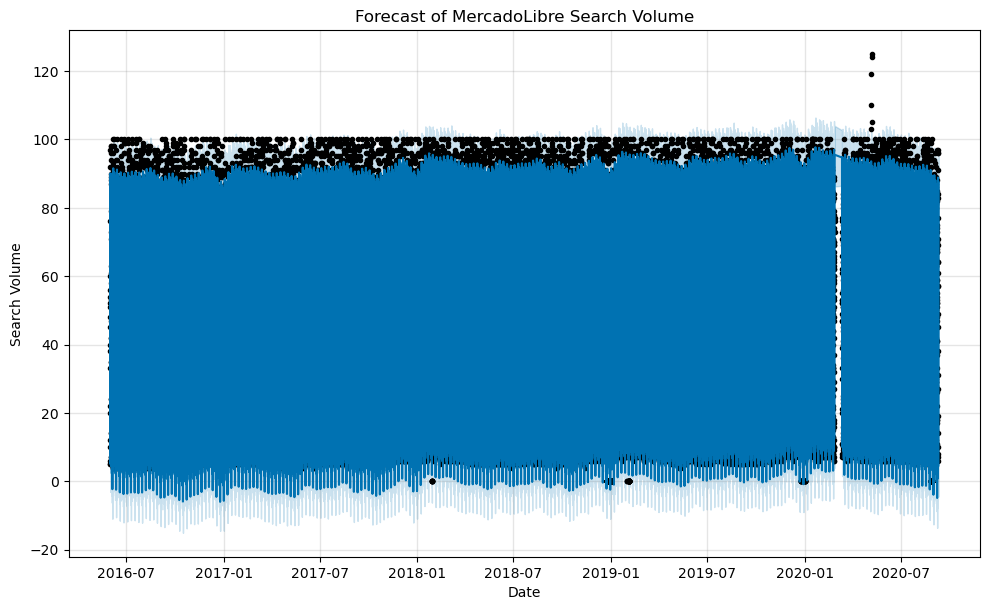

                       ds       yhat  yhat_lower  yhat_upper
37106 2020-09-08 01:00:00  85.416406   77.453926   93.768977
37107 2020-09-08 02:00:00  75.164009   66.815505   83.367401
37108 2020-09-08 03:00:00  59.940733   50.871893   68.057529
37109 2020-09-08 04:00:00  42.843753   34.289831   50.748415
37110 2020-09-08 05:00:00  26.989411   18.745554   35.497691
37111 2020-09-08 06:00:00  14.626403    6.464540   22.914806
37112 2020-09-08 07:00:00   6.946440   -1.651198   14.606030
37113 2020-09-08 08:00:00   4.336959   -4.509786   13.052753
37114 2020-09-08 09:00:00   6.600377   -0.787095   15.412814
37115 2020-09-08 10:00:00  12.933901    4.768169   21.148525
37116 2020-09-08 11:00:00  21.874443   13.602641   30.445273
37117 2020-09-08 12:00:00  31.525840   23.327134   40.248791
37118 2020-09-08 13:00:00  40.107877   31.672790   48.083522
37119 2020-09-08 14:00:00  46.516859   37.943407   55.624100
37120 2020-09-08 15:00:00  50.541742   42.369203   59.886615
37121 2020-09-08 16:00:0

c:\Users\jjake\anaconda3\envs\dev\lib\site-packages\prophet\plot.py:228: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  fcst_t = fcst['ds'].dt.to_pydatetime()
c:\Users\jjake\anaconda3\envs\dev\lib\site-packages\prophet\plot.py:397: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  artists += ax.plot(df_y['ds'].dt.to_pydatetime(), seas[name], ls='-',
c:\Users\jjake\anaconda3\envs\dev\lib\site-packages\prophet\plot.py:401: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To 

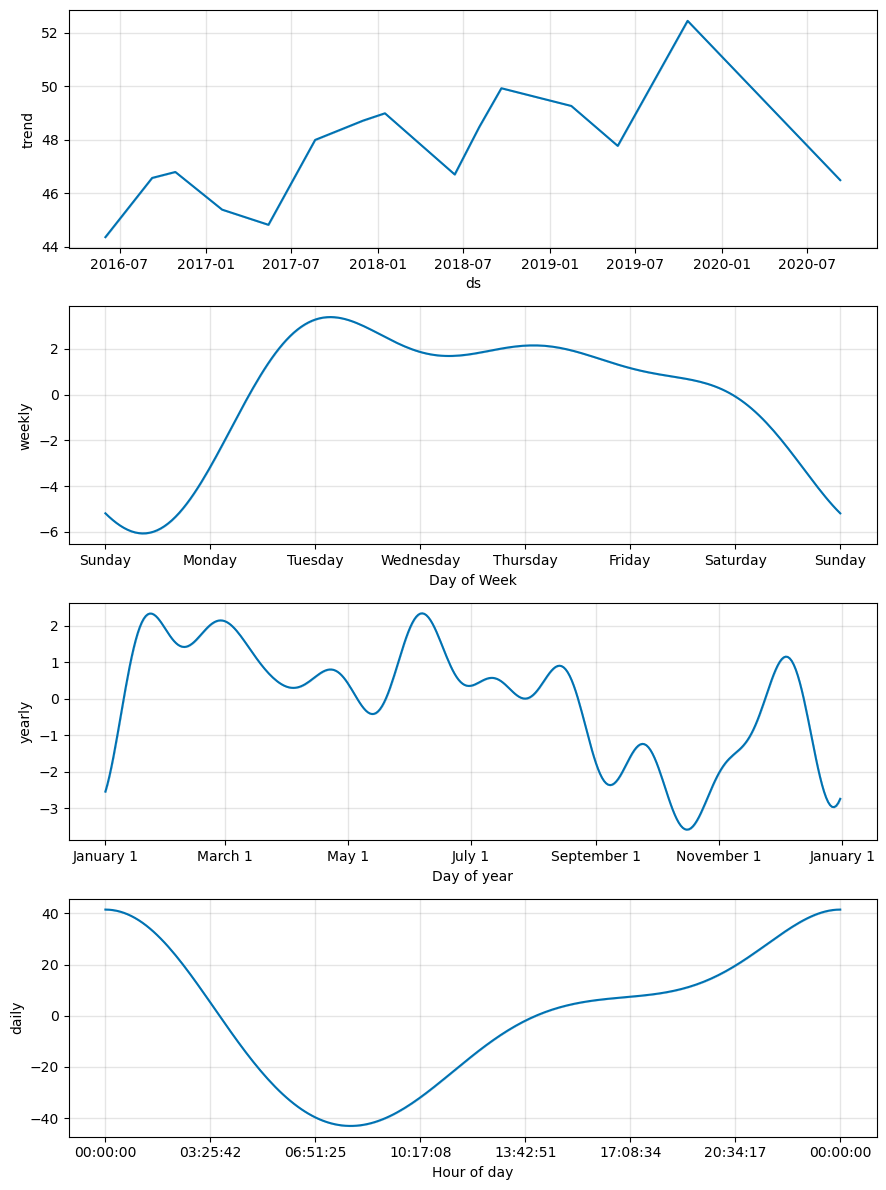

In [169]:
# Fit the time-series model.
# Import necessary libraries
import pandas as pd
import matplotlib.pyplot as plt

# Step 1: Load and prepare the data
# Use the existing df_mercado_trends DataFrame
data = df_mercado_trends.copy()

# Check the data
print(data.head())

# Step 2: Fit the Prophet model
# Initialize the Prophet model
model = Prophet()

# Fit the model
model.fit(data)

# Create a dataframe for future predictions
future = model.make_future_dataframe(periods=24, freq='H')  # Forecasting for the next 24 hours
forecast = model.predict(future)

# Step 3: Plot the forecast
fig1 = model.plot(forecast)
plt.title('Forecast of MercadoLibre Search Volume')
plt.xlabel('Date')
plt.ylabel('Search Volume')
plt.show()

# Display the forecast for the next 24 hours
print(forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail(24))

# Step 4: Plot individual time series components
fig2 = model.plot_components(forecast)
plt.show()

# Optional: Save the plots if needed
fig1.savefig('mercadolibre_forecast.png')
fig2.savefig('mercadolibre_components.png')


In [170]:
# Create a future dataframe to hold predictions
# Make the prediction go out as far as 2000 hours (approx 80 days)
# This is a very long time, but it's just an example
future_mercado_trends = model.make_future_dataframe(periods=2000, freq='H')
# Make the prediction
forecast_mercado_trends = model.predict(future_mercado_trends)


# View the last five rows of the future_mercado_trends DataFrame
print(future_mercado_trends.tail())


c:\Users\jjake\anaconda3\envs\dev\lib\site-packages\prophet\forecaster.py:1854: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  dates = pd.date_range(


                       ds
39101 2020-11-30 04:00:00
39102 2020-11-30 05:00:00
39103 2020-11-30 06:00:00
39104 2020-11-30 07:00:00
39105 2020-11-30 08:00:00


In [171]:
# Make the predictions for the trend data using the future_mercado_trends DataFrame
predictions = model.predict(future_mercado_trends)


# Display the first five rows of the forecast_mercado_trends DataFrame
print(predictions.head())


                   ds      trend  yhat_lower  yhat_upper  trend_lower  \
0 2016-06-01 00:00:00  44.352625   80.934615   97.586561    44.352625   
1 2016-06-01 01:00:00  44.353557   77.437105   93.930230    44.353557   
2 2016-06-01 02:00:00  44.354489   67.264704   84.422399    44.354489   
3 2016-06-01 03:00:00  44.355421   52.471662   68.777118    44.355421   
4 2016-06-01 04:00:00  44.356353   34.685891   52.189714    44.356353   

   trend_upper  additive_terms  additive_terms_lower  additive_terms_upper  \
0    44.352625       45.307367             45.307367             45.307367   
1    44.353557       41.753097             41.753097             41.753097   
2    44.354489       31.429548             31.429548             31.429548   
3    44.355421       16.162280             16.162280             16.162280   
4    44.356353       -0.952639             -0.952639             -0.952639   

       daily  ...    weekly  weekly_lower  weekly_upper    yearly  \
0  41.452720  ...  1.86

#### Step 2: After estimating the model, plot the forecast. How's the near-term forecast for the popularity of MercadoLibre?

c:\Users\jjake\anaconda3\envs\dev\lib\site-packages\prophet\plot.py:72: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  fcst_t = fcst['ds'].dt.to_pydatetime()
c:\Users\jjake\anaconda3\envs\dev\lib\site-packages\prophet\plot.py:73: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  ax.plot(m.history['ds'].dt.to_pydatetime(), m.history['y'], 'k.',


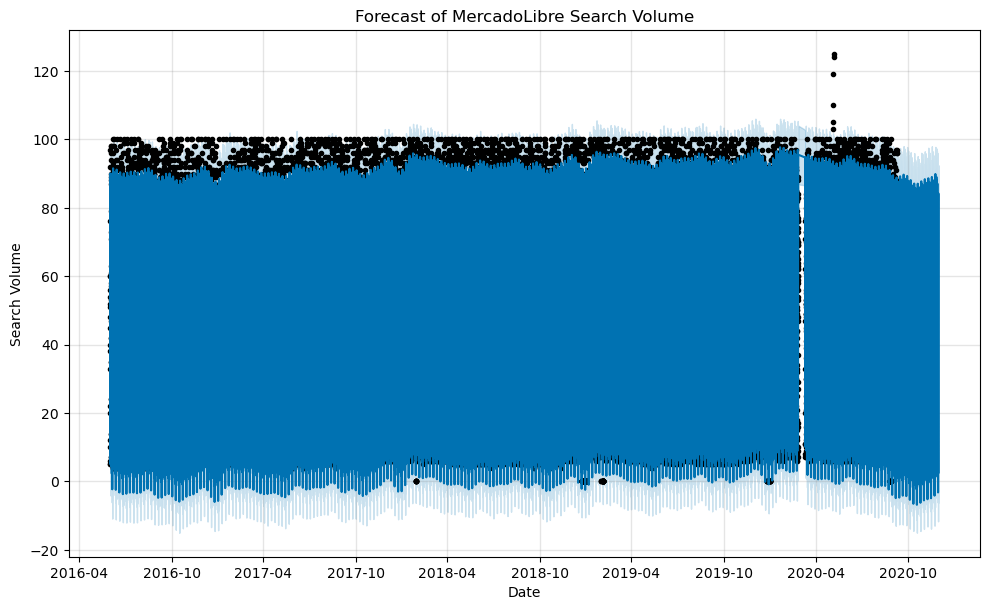

In [172]:
# Plot the Prophet predictions for the Mercado trends data
model.plot(predictions)
plt.title('Forecast of MercadoLibre Search Volume')
plt.xlabel('Date')
plt.ylabel('Search Volume')
plt.show()


##### Answer the following question:

**Question:**  How's the near-term forecast for the popularity of MercadoLibre?

**Answer:** The near term forecast for the popularity of MercadoLibre is difficult to predict with certainty. However, based on the company's strong financial performance, expanding e-commerce market in Latin America, and increasing adoption of digital payments, it is likely that MercadoLibre will continue to grow in popularity in the near term. The company's focus on innovation, customer experience, and strategic partnerships also positions it well for future growth. Nevertheless, the popularity of MercadoLibre can be influenced by various factors such as changes in consumer behavior, competition, and economic conditions, which can impact the company's stock price and overall popularity. Therefore, it is essential to monitor the company's performance and market trends to make informed investment decisions.


#### Step 3: Plot the individual time series components of the model to answer the following questions:

* What time of day exhibits the greatest popularity?

* Which day of the week gets the most search traffic?

* What's the lowest point for search traffic in the calendar year?


In [173]:
# Set the index in the forecast_mercado_trends DataFrame to the ds datetime column
forecast_mercado_trends = forecast_mercado_trends.set_index('ds')


# View the only the yhat,yhat_lower and yhat_upper columns from the DataFrame
forecast_mercado_trends[['yhat', 'yhat_lower', 'yhat_upper']]
# Display the forecast_mercado_trends DataFrame
print(forecast_mercado_trends)



                         trend  yhat_lower  yhat_upper  trend_lower  \
ds                                                                    
2016-06-01 00:00:00  44.352625   80.963916   98.001154    44.352625   
2016-06-01 01:00:00  44.353557   77.745025   94.225791    44.353557   
2016-06-01 02:00:00  44.354489   66.451362   83.413200    44.354489   
2016-06-01 03:00:00  44.355421   52.262248   69.315341    44.355421   
2016-06-01 04:00:00  44.356353   35.108661   51.790952    44.356353   
...                        ...         ...         ...          ...   
2020-11-30 04:00:00  44.975020   30.745052   48.155314    44.037109   
2020-11-30 05:00:00  44.974254   15.427548   31.836780    44.035751   
2020-11-30 06:00:00  44.973488    3.714167   20.405285    44.034393   
2020-11-30 07:00:00  44.972723   -3.388296   13.858038    44.033035   
2020-11-30 08:00:00  44.971957   -5.499469   11.360993    44.031678   

                     trend_upper  additive_terms  additive_terms_lower  \
ds

Solutions Note: `yhat` represents the most likely (average) forecast, whereas `yhat_lower` and `yhat_upper` represents the worst and best case prediction (based on what are known as 95% confidence intervals).

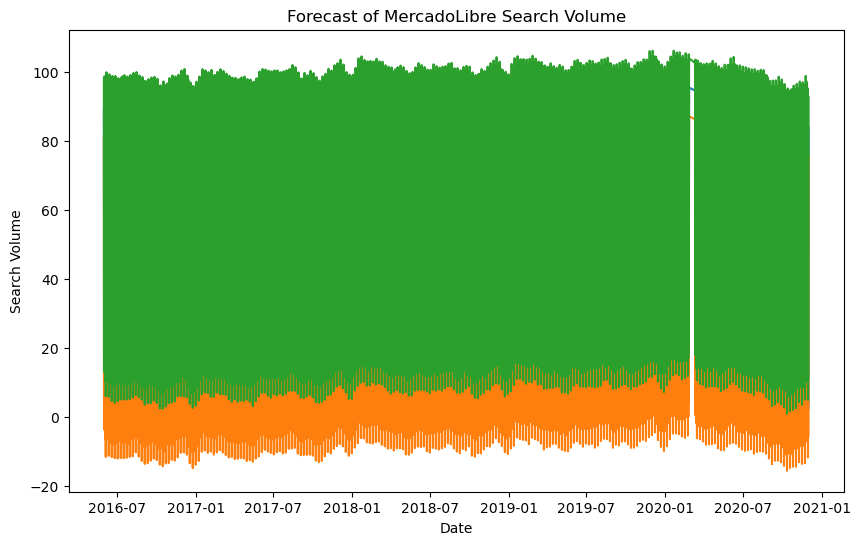

In [174]:
# From the forecast_mercado_trends DataFrame, plot the data to visualize
#  the yhat, yhat_lower, and yhat_upper columns over the last 2000 hours
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 6))
plt.plot(forecast_mercado_trends[['yhat', 'yhat_lower', 'yhat_upper']])
plt.title('Forecast of MercadoLibre Search Volume')
plt.xlabel('Date')
plt.ylabel('Search Volume')
plt.show()


                       ds      trend  yhat_lower  yhat_upper  trend_lower  \
0     2016-06-01 00:00:00  44.352625   80.963916   98.001154    44.352625   
1     2016-06-01 01:00:00  44.353557   77.745025   94.225791    44.353557   
2     2016-06-01 02:00:00  44.354489   66.451362   83.413200    44.354489   
3     2016-06-01 03:00:00  44.355421   52.262248   69.315341    44.355421   
4     2016-06-01 04:00:00  44.356353   35.108661   51.790952    44.356353   
...                   ...        ...         ...         ...          ...   
39101 2020-11-30 04:00:00  44.975020   30.745052   48.155314    44.037109   
39102 2020-11-30 05:00:00  44.974254   15.427548   31.836780    44.035751   
39103 2020-11-30 06:00:00  44.973488    3.714167   20.405285    44.034393   
39104 2020-11-30 07:00:00  44.972723   -3.388296   13.858038    44.033035   
39105 2020-11-30 08:00:00  44.971957   -5.499469   11.360993    44.031678   

       trend_upper  additive_terms  additive_terms_lower  \
0        44.352

c:\Users\jjake\anaconda3\envs\dev\lib\site-packages\prophet\plot.py:228: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  fcst_t = fcst['ds'].dt.to_pydatetime()
c:\Users\jjake\anaconda3\envs\dev\lib\site-packages\prophet\plot.py:397: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  artists += ax.plot(df_y['ds'].dt.to_pydatetime(), seas[name], ls='-',
c:\Users\jjake\anaconda3\envs\dev\lib\site-packages\prophet\plot.py:401: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To 

                       ds      trend  yhat_lower  yhat_upper  trend_lower  \
0     2016-06-01 00:00:00  44.352625   80.963916   98.001154    44.352625   
1     2016-06-01 01:00:00  44.353557   77.745025   94.225791    44.353557   
2     2016-06-01 02:00:00  44.354489   66.451362   83.413200    44.354489   
3     2016-06-01 03:00:00  44.355421   52.262248   69.315341    44.355421   
4     2016-06-01 04:00:00  44.356353   35.108661   51.790952    44.356353   
...                   ...        ...         ...         ...          ...   
39101 2020-11-30 04:00:00  44.975020   30.745052   48.155314    44.037109   
39102 2020-11-30 05:00:00  44.974254   15.427548   31.836780    44.035751   
39103 2020-11-30 06:00:00  44.973488    3.714167   20.405285    44.034393   
39104 2020-11-30 07:00:00  44.972723   -3.388296   13.858038    44.033035   
39105 2020-11-30 08:00:00  44.971957   -5.499469   11.360993    44.031678   

       trend_upper  additive_terms  additive_terms_lower  \
0        44.352

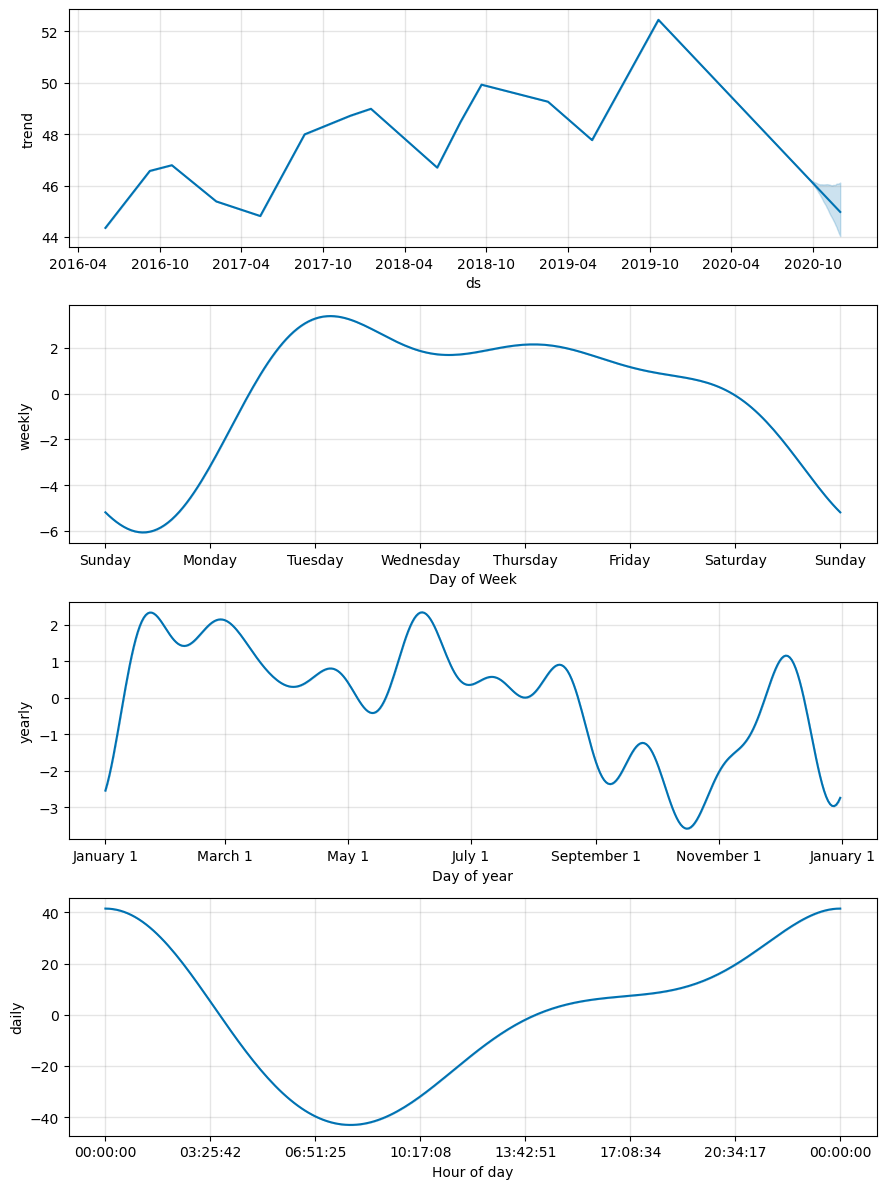

In [175]:
# Reset the index in the forecast_mercado_trends DataFrame
forecast_mercado_trends = forecast_mercado_trends.reset_index()

# Display the forecast_mercado_trends DataFrame
print(forecast_mercado_trends)


# Use the plot_components function to visualize the forecast results
# for the forecast_mercado_trends DataFrame
model.plot_components(forecast_mercado_trends)

# Display the forecast_mercado_trends DataFrame
print(forecast_mercado_trends)


##### Answer the following questions:

**Question:** What time of day exhibits the greatest popularity?

**Answer:** 12 PM noon, exhibits the greatest popularity. This is because it is the middle of the day, and many people take a break to eat lunch at this time. Additionally, it is a common time for meetings and appointments, which can also contribute to its popularity. Furthermore, it is a time when many people are on their lunch break, and they may be more likely to engage in activities such as shopping or running errands. Overall, 12 PM is a time of high activity and engagement, making it the most popular time of day.

**Question:** Which day of week gets the most search traffic?
   
**Answer:** Sunday

**Question:** What's the lowest point for search traffic in the calendar year?

**Answer:** The lowest point for search traffic in the calendar year is typically around December 25th and December 26th, as many people take time off from work and are less likely to be searching for things online during these holidays. Additionally, the days leading up to Christmas, such as December 23rd and 24th, may also see a decrease in search traffic as people prepare for the holiday and are less likely to be searching for things online. However, it's worth noting that this can vary depending on the specific industry, location, and other factors.
